# Load data

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

In [14]:
def normalize_mid_points(X, ndims=3):
    """Calculate middle point between two hips 
         and substract this point from other coordinates
       Params:
         X - array of shape (Frames, KeyPoints, Dim), 
             Frames - number of extracted video frames,
             KeyPoints = 17 
             Dim = 3 (x, y, score) 
       Returns:
         normalized coords with concatenated mid point
        """
    left_hip, right_hip = 11, 12
    N = X.shape[0]
    mid_points = (X[:, left_hip, :] + X[:, right_hip, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = X - mp
    
    if ndims==3:
        return np.concatenate([x_n, mp], axis=1).reshape(N, 54)
    elif ndims==2:
        return np.concatenate([x_n[:, :, :2], mp[:, :, :2]], axis=1).reshape(N, 36)
    else:
        raise("Select number of dimensions")

def read_data(name, normalize_mp='2D'):
    """ Read numpy array with saved keypoints
      Params:
        name - file name without .npy extension 
        normalize_mp - '3D' for keep scores, '2D' - keep (x,y) only
    """
    
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()
    
    N = int(re.findall(r'\d+', labels[0])[0])
    X = np.load(f'data/keypoints/{name}.npy')
    X = X.reshape((N, 17, 3))
    y = np.zeros(N, dtype=int)
    
    for lab in labels:
        C = re.findall(r'\d:', lab)

        if len(C) == 1:
            C = int(C[0][0])
            idxs = re.findall(r'\d+-\d+', lab)
            for idx in idxs:
                start, stop = idx.split('-')
                y[int(start): int(stop)] = C
    if normalize_mp == '3D':
        X = normalize_mid_points(X)
    elif normalize_mp == '2D':
        X = normalize_mid_points(X, ndims=2)
    else:
        X = X.reshape(N, 51)
        
    print(X.shape)
    return X, y

In [5]:
files = os.listdir('data/labels/')
X_list, y_list = [], []
X_list_val, y_list_val = [], []

In [6]:
train_files = [f for f in files if '_1' in f]
val_files = [f for f in files if '_2' in f]

In [15]:
for f in train_files:
    X, y = read_data(f)
    X_list.append(X)
    y_list.append(y)

(1200, 36)
(746, 36)
(1100, 36)
(802, 36)
(952, 36)
(858, 36)


In [16]:
for f in val_files:
    X, y = read_data(f)
    X_list_val.append(X)
    y_list_val.append(y)

(993, 36)
(703, 36)
(1051, 36)
(792, 36)
(643, 36)
(1186, 36)


In [17]:
X_train = np.concatenate(X_list)
y_train = np.concatenate(y_list)
X_val = np.concatenate(X_list_val)
y_val = np.concatenate(y_list_val)

In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11316, 36), (11316,), (5368, 36), (5368,))

In [22]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

def format_feature_names(names, ndims=3):
    feature_names = []
    for name in list(KEYPOINT_DICT.keys()):
        feature_names.append(name+'-x')
        feature_names.append(name+'-y')
        if ndims==3:
            feature_names.append(name+'-z')
    feature_names.append('mid_point-x')
    feature_names.append('mid_point-y')
    if ndims==3:
        feature_names.append('mid_point-z')
    return feature_names

feature_names = format_feature_names(list(KEYPOINT_DICT.keys()), ndims=2)

In [23]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,11316.0,-0.215987,0.020581,-0.286912,-0.231231,-0.217968,-0.201670,-0.137288
nose-y,11316.0,-0.099373,0.060290,-0.319833,-0.141223,-0.101188,-0.054012,0.133204
left_eye-x,11316.0,-0.228067,0.021247,-0.294852,-0.243813,-0.229817,-0.213000,-0.143396
left_eye-y,11316.0,-0.085212,0.066451,-0.313134,-0.132676,-0.086532,-0.034463,0.144004
right_eye-x,11316.0,-0.228127,0.020959,-0.295746,-0.243888,-0.230081,-0.212890,-0.149324
right_eye-y,11316.0,-0.095476,0.059404,-0.314587,-0.136915,-0.098172,-0.049768,0.126586
left_ear-x,11316.0,-0.228428,0.022716,-0.277814,-0.246443,-0.230224,-0.210957,-0.148176
left_ear-y,11316.0,-0.022547,0.064831,-0.242360,-0.064231,-0.020757,0.026669,0.157801
right_ear-x,11316.0,-0.230895,0.022257,-0.282105,-0.248717,-0.232656,-0.212928,-0.158699
right_ear-y,11316.0,-0.048343,0.051595,-0.248735,-0.081833,-0.048796,-0.008734,0.105384


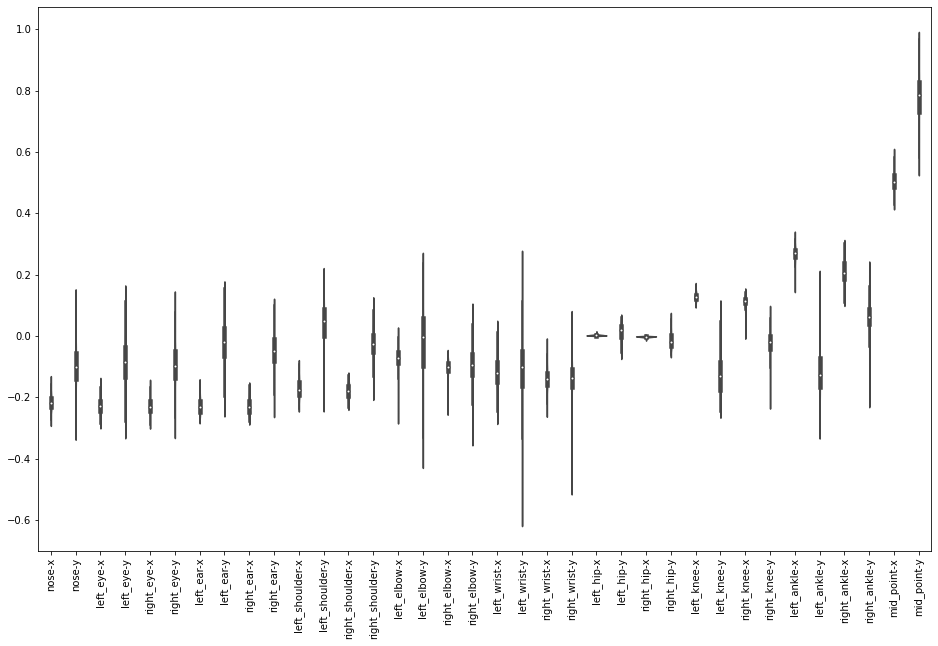

In [25]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [26]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_val.shape[0] // time_steps

In [28]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 36)
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_val.shape

((377, 30, 36), (178, 30, 36))

## LSTM

In [29]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

2021-11-09 19:58:56.618948: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def model_builder(hp):
    # Hyperparams
    hp_ru = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)
    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)
    hp_reg1 = hp.Float('dense1_reg', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense2_reg', min_value=1e-4, max_value=1e-2)
    
    hp_dp = hp.Float('dropout', min_value=0., max_value=0.4)
    hp_rec_dp = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    hp_kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    
    # Model
    norm = tf.keras.layers.LayerNormalization(axis=1)
    kernel_reg = K.regularizers.l2(hp_kernel_reg)
    recurrent_reg = K.regularizers.l2(hp_recur_reg)
    act_reg = K.regularizers.l2(hp_act_reg)
    lstm = K.layers.LSTM(hp_ru,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True,
                         kernel_regularizer=kernel_reg,
                         recurrent_regularizer=recurrent_reg,
                         activity_regularizer=act_reg,
                         dropout=hp_dp,
                         recurrent_dropout=hp_rec_dp
                        )
    dense1 = K.layers.Dense(hp_du1, activation='relu', 
                            kernel_regularizer=K.regularizers.l2(hp_reg1))
    dense2 = K.layers.Dense(hp_du2, activation='relu', 
                           kernel_regularizer=K.regularizers.l2(hp_reg2))
    out = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([norm, lstm, dense1, dense2, out])
    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [31]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=1, validation_data=(X_val, y_val), 
             epochs=32, callbacks=[stop_early])

Trial 30 Complete [00h 01m 13s]
val_accuracy: 0.815168559551239

Best val_accuracy So Far: 0.8181647658348083
Total elapsed time: 00h 17m 16s
INFO:tensorflow:Oracle triggered exit


In [32]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units': 72,
 'units1': 80,
 'units2': 64,
 'dense1_reg': 0.002674642711350214,
 'dense2_reg': 0.00029406285857301595,
 'dropout': 0.14025233956640423,
 'rec_dropout': 0.06808928471555396,
 'kernel_reg': 8.083461993086269e-05,
 'recur_reg': 0.0001007391702590175,
 'act_reg': 0.00043967606917372665,
 'learning_rate': 0.0008907538850196228,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': 'd97fc7865f552f269da757b56c267b21'}

In [33]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_val, y_val), 
                    epochs=64,
                   callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64
377/377 [==============================] - 6s 11ms/step - loss: 1.3628 - accuracy: 0.6111 - val_loss: 1.0955 - val_accuracy: 0.6629
Epoch 2/64
377/377 [==============================] - 4s 10ms/step - loss: 0.8666 - accuracy: 0.7554 - val_loss: 0.8851 - val_accuracy: 0.7476
Epoch 3/64
377/377 [==============================] - 4s 10ms/step - loss: 0.6893 - accuracy: 0.8253 - val_loss: 0.8925 - val_accuracy: 0.7547
Epoch 4/64
377/377 [==============================] - 4s 10ms/step - loss: 0.6183 - accuracy: 0.8475 - val_loss: 0.7973 - val_accuracy: 0.7734
Epoch 5/64
377/377 [==============================] - 4s 10ms/step - loss: 0.5389 - accuracy: 0.8706 - val_loss: 0.7153 - val_accuracy: 0.7991
Epoch 6/64
377/377 [==============================] - 4s 10ms/step - loss: 0.5084 - accuracy: 0.8746 - val_loss: 0.7538 - val_accuracy: 0.7963
Epoch 7/64
377/377 [==============================] - 4s 10ms/step - loss: 0.4795 - accuracy: 0.8884 - val_loss: 0.7068 - val_accuracy: 0.8002

Epoch 58/64
377/377 [==============================] - 4s 10ms/step - loss: 0.2054 - accuracy: 0.9719 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 59/64
377/377 [==============================] - 5s 13ms/step - loss: 0.2022 - accuracy: 0.9723 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 60/64
377/377 [==============================] - 5s 14ms/step - loss: 0.2083 - accuracy: 0.9684 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 61/64
377/377 [==============================] - 5s 13ms/step - loss: 0.2049 - accuracy: 0.9711 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 62/64
377/377 [==============================] - 4s 12ms/step - loss: 0.2056 - accuracy: 0.9698 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 63/64
377/377 [==============================] - 4s 12ms/step - loss: 0.2041 - accuracy: 0.9710 - val_loss: 0.7936 - val_accuracy: 0.8077
Epoch 64/64
377/377 [==============================] - 4s 10ms/step - loss: 0.2025 - accuracy: 0.9717 - val_loss: 0.7936 - val_accuracy:

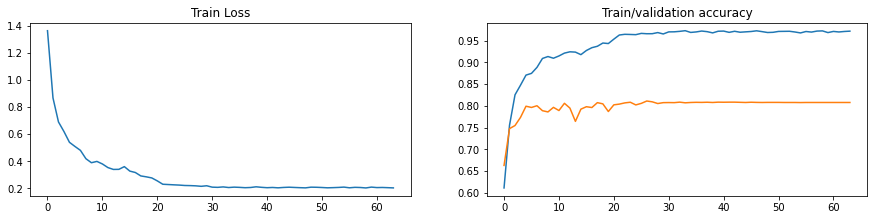

In [34]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Conclusion 

We need more data to avoid overfitting

# Convert the model

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2021-11-09 20:24:01.856296: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpbbai7pc9/assets


2021-11-09 20:24:04.492900: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-11-09 20:24:04.493034: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-09 20:24:04.592556: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 188 nodes (0), 233 edges (0), time = 16.983ms.
  function_optimizer: Graph size after: 188 nodes (0), 233 edges (0), time = 6.207ms.
Optimization results for grappler item: sequential_lstm_while_body_483154
  function_optimizer: function_optimizer did nothing. time = 0.019ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.
Optimization results for grappler item: sequential_lstm_while_cond_483153
  function_optimizer: function_optimizer did nothing. time = 0.016ms.
  functio

In [36]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10
x = tf.reshape(X_val, (-1, time_steps, 36))
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = model.predict(x[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], x[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.


# Moving most frequent smoothing

In [37]:
y_pred = np.argmax(model(x).numpy(), axis=-1).ravel()
y_val_np = np.concatenate(y_list_val)[:N_val*time_steps]

In [38]:
# [1,1,1,1,3,3,1,1] -> [1]
# moving window across padded y_pred
# output element is most frequent in window

win_size = time_steps // 2
mf_smooth = np.zeros(y_pred.shape[0]+win_size)
for i in range(len(y_pred) - win_size):
    window = y_pred[i:i+win_size]
    bins = np.bincount(window)
    mf_smooth[i+win_size//2] = np.argmax(bins)

mf_smooth = mf_smooth[:-win_size]

In [39]:
len(mf_smooth), len(y_pred), len(y_val_np)

(5340, 5340, 5340)

In [40]:
print(np.mean(y_val_np==y_pred))
print(np.mean(y_val_np==mf_smooth))

0.8076779026217229
0.8134831460674158


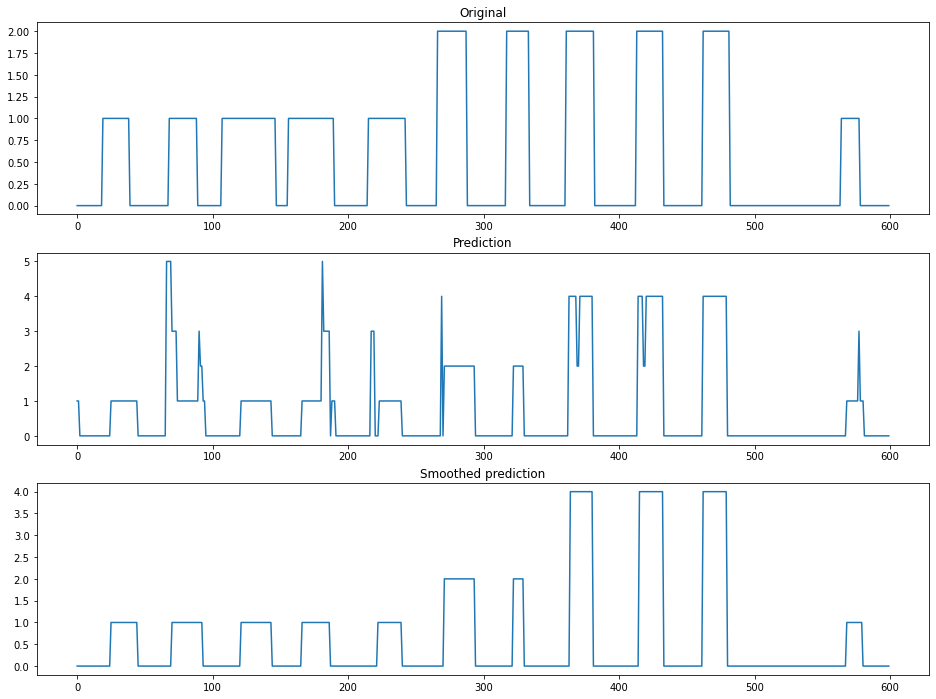

In [41]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.title('Original')
plt.plot(y_val_np[:600])

plt.subplot(3, 1, 2)
plt.title('Prediction')
plt.plot(y_pred[:600])

plt.subplot(3, 1, 3)
plt.title('Smoothed prediction')
plt.plot(mf_smooth[:600])


Thanks to:  
https://github.com/keras-team/keras-tuner